In [1]:
# 참고자료: https://github.com/davidsandberg/facenet
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import math

# 주성분분석(Principal Analysis)을 하기위한 라이브러리
from sklearn.decomposition import PCA

# 파일 경로 확인용
import os
import glob

# .py 파일 가져오기
# import (폴더이름.)파일이름
import src.facenet as facenet
import src.align.detect_face as detect_face

# path를 입력받아 immread하고, BGR2RGB로 convert하는 함수
def MyImread(path):
    bgr_img = cv2.imread(path)
    assert bgr_img is not None, "영상 로드 실패"
    
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    return rgb_img

In [2]:
## 사용할 함수

# 학습되어있는 모델을 로드하는 함수
#    입력: protobuf 파일(모델이 정의되어 있음)
#    리턴:
#        - single_image: 영상을 입력하는 placeholder (session.run feed_dict에 사용)
#        - embeddings: 네트워크의 출력 값, 512차원의 추출된 얼굴 특징 벡터

def load_model(pb_path, image_size=(160,160)):
    tf.reset_default_graph()
    
    single_image = tf.placeholder(tf.int32, (None,None,3))
    float_image = tf.cast(single_image, tf.float32)
    float_image = float_image / 255
    batch_image = tf.expand_dims(float_image, 0)
    resized_image = tf.image.resize(batch_image, image_size)
    
    phase_train = tf.placeholder_with_default(False, shape=[])
    
    input_map = {'image_batch':resized_image, 'phase_train':phase_train}
    model = facenet.load_model(pb_path, input_map)
    
    embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
    
    return single_image, embeddings

# 영상 경로를 입력박아 로드하고, return해주는 함수
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    return image

# 두 벡터간의 거리를 계산하는 함수
def calc_distance(embedding1, embedding2):
    # Euclidian distance
    diff = np.subtract(embedding1, embedding2)
    dist = np.sum(np.square(diff),0) 
    return dist

# 얼굴 검출
# bounding_boxes, points = detect_face.detect_face(image, minsize, pnet, rnet, onet, threshold, factor)

In [3]:
## 모델 및 세션 선언
tf.reset_default_graph()
single_image, embeddings = load_model("./models/20180402-114759.pb")

sess = tf.Session()

## 학습되어 있는 detection 모델 로드
pnet, rnet, onet = detect_face.create_mtcnn(sess, None)

Model filename: ./models/20180402-114759.pb
Instructions for updating:
Use tf.gfile.GFile.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [4]:
## 내 얼굴의 특징벡터(embedding)추출

path_me = glob.glob("./project1/data/faces/me/*")

embed_me = []

for path in path_me:
    img = load_image(path)
    result = sess.run(embeddings, feed_dict={single_image:img})
    result = result[0]
    embed_me.append(result)
    
embed_me = np.array(embed_me)
print(embed_me.shape)

(33, 512)


In [5]:
## 다른 사람 얼굴의 특징벡터(embedding)추출

path_other1 = glob.glob("./data/faces/other1/*")

embed_other1 = []

for path in path_other1:
    img = load_image(path)
    result = sess.run(embeddings, feed_dict={single_image:img})
    result = result[0]
    embed_other1.append(result)
    
embed_other1 = np.array(embed_other1)
print(embed_other1.shape)

path_other2 = glob.glob("./data/faces/other2/*")

embed_other2 = []

for path in path_other2:
    img = load_image(path)
    result = sess.run(embeddings, feed_dict={single_image:img})
    result = result[0]
    embed_other2.append(result)
    
embed_other2 = np.array(embed_other2)
print(embed_other2.shape)

(5, 512)
(22, 512)


In [6]:
# 얼굴 특징벡터 간의 거리 확인
# 내얼굴 1과 내얼굴 2의 거리 확인
print(calc_distance(embed_me[0], embed_me[1]))

# 내얼굴 1과 다른사람 얼굴 1의 거리 확인
print(calc_distance(embed_me[0], embed_other1[0]))

0.25440568
1.9826021


In [7]:
# 기준이 되는 얼굴 임베딩 설정
base_embed = embed_me[0]

print("---------- 내 얼굴과의 거리 ----------")
# 얼굴 0~N 까지 확인
for e in embed_me:
    print(calc_distance(base_embed, e))
    
print("\n\n")
print("---------- 다른 사람 얼굴과의 거리 ----------")
# 다른 사람1, 2를 묶어서 확인
embed_others = np.concatenate((embed_other1, embed_other2), axis=0)
for e in embed_others:
    print(calc_distance(base_embed, e))

---------- 내 얼굴과의 거리 ----------
0.0
0.25440568
0.32737476
0.51248014
0.7384288
0.48129958
0.33555388
0.47563687
0.3923577
0.44124377
0.55606544
0.35561752
0.46319038
0.36075008
0.3632886
0.389556
0.5572383
0.5111393
0.5431389
0.37135983
0.54040504
0.4422124
0.47523654
0.6505408
0.6153608
0.8027885
0.5117248
0.5356058
0.48160684
0.42867082
0.5500677
0.5379881
0.4592921



---------- 다른 사람 얼굴과의 거리 ----------
1.9826021
1.9660068
2.0650756
2.1212792
1.7452468
1.8273803
1.8323042
1.8692644
1.8892179
1.8973544
1.9185641
1.9699279
1.8495053
1.943949
2.0061598
1.9909546
1.81219
1.6928296
1.9928223
1.7658846
1.8973328
2.085444
1.7838733
1.9395164
1.8967055
2.0314188
1.7393726


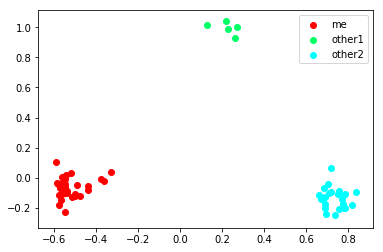

In [8]:
## PCA를 사용한 시각화(512->2차원으로 감소)
# 모든 임베딩을 묶음
all_embeddings = np.concatenate((embed_me, embed_other1, embed_other2), axis=0)

# PCA 클래스 선언 (n_component는 축소할 차원을 의미)
pca = PCA(n_components=2)

# PCA 계산 (이후 pca.transform 함수를 사용하여 512차원을 2차원으로 축소)
pca.fit(all_embeddings)

# PCA를 사용하여 차원 축소
xy_me = pca.transform(embed_me)
xy_other1 = pca.transform(embed_other1)
xy_other2 = pca.transform(embed_other2)

ax = plt.figure()

sc1 = plt.scatter(xy_me[:,0], xy_me[:,1], color=(1, 0, 0))
sc2 = plt.scatter(xy_other1[:,0], xy_other1[:,1], color=(0, 1, 0.4))
sc3 = plt.scatter(xy_other2[:,0], xy_other2[:,1], color=(0, 1, 1))

plt.legend([sc1,sc2,sc3], ["me", "other1", "other2"], loc="upper right")

In [9]:
## 내 얼굴인지 분류
# 영상 경로를 자유롭게 수정
x_path = "./project1/data/faces/me/20190319_222026.jpg"

image_x = load_image(x_path)
result_x = sess.run(embeddings, feed_dict={single_image:image_x})
result_x = result_x[0]

distance_th = 1.2 # 거리가 얼마 미만이여야 나로 분류할지

distance1 = calc_distance(embed_me[0], result_x)
distance2 = calc_distance(embed_me[3], result_x)

avg_distance = (distance1+distance2) / 2
print("distance:", avg_distance)

if(avg_distance < distance_th):
    print(x_path, "는 내 얼굴입니다")
else:
    print(x_path, "는 내 얼굴이 아닙니다")

distance: 0.2562400698661804
./project1/data/faces/me/20190319_222026.jpg 는 내 얼굴입니다


In [13]:
# 영상을 입력받아 face detection을 수행하고,
# 얼굴 영역에 네모를 그려 return해주는 함수
def FaceDetection(img):
    color = (255, 0, 0) # 얼굴 영역을 표시할 네모의 색상 지정
    color_red = (0, 255, 0) # 내얼굴이 아닌 얼굴
    thickness = 2 # 네모의 두께
    
    result_img = img.copy()
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 이미 학습되어있는 Haar Cascade Classifier 로드
    face_cascade = cv2.CascadeClassifier("./practice5/haarcascade_frontalface_default.xml")
    
    # 얼굴 검출 수행
    faces = face_cascade.detectMultiScale(gray_img, 1.1, 5)
    
    if(avg_distance < distance_th):
        # 검출된 얼굴 영역 그리기
        for (x,y,w,h) in faces:
            cv2.rectangle(result_img, (x,y), (x+w,y+h), color, 2)
    else:
        for (x,y,w,h) in faces:
            cv2.rectangle(result_img, (x,y), (x+w,y+h), color_red, 2)
    
    return result_img

In [14]:
# 내얼굴과 다른사람의 얼굴이 있는영상으로 내얼굴 검출
cap = cv2.VideoCapture("./project1/data/faces/video/people.mp4")

while(cap.isOpened()):
    ret, frame = cap.read()
    
    frame = cv2. resize(frame,(400,225))
    
    detected_faces = FaceDetection(frame)
    
    cv2.imshow('frame', frame)
    cv2.imshow('detected', detected_faces)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
0. 내 얼굴들의 임베딩을 미리 계산(실습 1의 embed_me)
1. 동영상 로드
2. 프레임 별로 얼굴 검출
3. 검출된 각 얼굴(2번)에 대하여 내 얼굴들(0번)과 거리 비교
4. 거리가 일정 값 미만이면 내 얼굴로 인식(평균, top-k 등 다양한 방법 사용 가능)
5. 결과 표시(bounding box 빨강, 초록 그리기)